In [ ]:
!python -m spacy download es_core_news_md -q
!pip install pyspellchecker

2023-12-17 10:11:27.882560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 10:11:27.882632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 10:11:27.884473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 10:11:31.445326: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 18.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 1

In [ ]:
import torch
from torch import nn
from transformers import get_linear_schedule_with_warmup, BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import math
import time
from matplotlib import pyplot as plt
from torch.optim import AdamW

# Cargar los datos desde el archivo CSV
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/transfomer/datosChat.csv')

# Creamos un objeto LabelEncoder
label_encoder = LabelEncoder()
# Convertimos las etiquetas de texto a números enteros
df['label_codigo'] = label_encoder.fit_transform(df['label'])
# Obtenemos la correspondencia entre números y etiquetas
label_dict = {i: label for i, label in enumerate(label_encoder.classes_)}
#print(label_dict)

# Definir las características y etiquetas
data_texto = df["pregunta_limpia"].tolist()
data_labels = df["label_codigo"].tolist()

# Dividir en conjuntos de entrenamiento, validación y prueba
train_text, temp_text, train_labels, temp_labels = train_test_split(data_texto, data_labels, random_state=2023,
                                                                    test_size=0.3, stratify=df['label_codigo'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2023,
                                                                test_size=0.5, stratify=temp_labels)

# Tokenizar los datos
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

def encode(docs):
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=64, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

train_input_ids, train_att_masks = encode(train_text)
val_input_ids, val_att_masks = encode(val_text)
test_input_ids, test_att_masks = encode(test_text)

# Convertir a Tensores de PyTorch
train_y = torch.LongTensor(train_labels)
val_y = torch.LongTensor(val_labels)
test_y = torch.LongTensor(test_labels)

# Definir conjuntos de datos y dataloaders
BATCH_SIZE = 32
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

val_dataset = TensorDataset(val_input_ids, val_att_masks, val_y)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

# Definir el modelo FineTuningBERT
class FineTuningBERT(nn.Module):
    def __init__(self, bert):
        super(FineTuningBERT, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(768, 64)
        self.ReLu = nn.ReLU()
        self.fc2 = nn.Linear(64, len(df.label.unique()))  # Ajustar el número de clases

    def forward(self, sent_id, mask):
        outputs = self.bert(sent_id, attention_mask=mask)
        cls_hs = outputs['pooler_output']

        x = self.dropout(cls_hs)
        x = self.fc1(x)
        x = torch.nn.ReLU()(x)
        x = self.fc2(x)
        return x

# Inicializar el modelo BERT pre-entrenado
bert_model = BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", return_dict=True)

# Inicializar el modelo FineTuningBERT
model = FineTuningBERT(bert_model)

# Definir la función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
LEARNING_RATE = 2e-6
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
EPOCHS = 300  # Cambiar el número de épocas según sea necesario
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*EPOCHS)

# Entrenamiento y validación del modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FineTuningBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, masks)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        loss.backward()
        optimizer.step()
        scheduler.step()

    train_loss_values.append(train_loss / len(train_dataloader))
    train_accuracy_values.append((correct_train / total_train) * 100)

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    valid_pred = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch
            outputs = model(inputs, masks)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            valid_pred.append(predicted.cpu().detach().numpy())  # Guardar las predicciones del conjunto de validación
    val_loss_values.append(val_loss / len(val_dataloader))
    val_accuracy_values.append((correct_val / total_val) * 100)
    valid_pred = np.concatenate(valid_pred)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {train_loss_values[-1]:.4f} - Train Accuracy: {train_accuracy_values[-1]:.2f}% - Val Loss: {val_loss_values[-1]:.4f} - Val Accuracy: {val_accuracy_values[-1]:.2f}%")


Epoch [1/300] - Train Loss: 4.5358 - Train Accuracy: 1.54% - Val Loss: 4.5291 - Val Accuracy: 1.44%
Epoch [2/300] - Train Loss: 4.5313 - Train Accuracy: 1.08% - Val Loss: 4.5246 - Val Accuracy: 1.44%
Epoch [3/300] - Train Loss: 4.5276 - Train Accuracy: 1.84% - Val Loss: 4.5188 - Val Accuracy: 1.44%
Epoch [4/300] - Train Loss: 4.5199 - Train Accuracy: 1.69% - Val Loss: 4.5127 - Val Accuracy: 1.44%
Epoch [5/300] - Train Loss: 4.5128 - Train Accuracy: 1.84% - Val Loss: 4.5061 - Val Accuracy: 2.16%
Epoch [6/300] - Train Loss: 4.5118 - Train Accuracy: 1.54% - Val Loss: 4.4968 - Val Accuracy: 2.16%
Epoch [7/300] - Train Loss: 4.4968 - Train Accuracy: 1.54% - Val Loss: 4.4858 - Val Accuracy: 2.88%
Epoch [8/300] - Train Loss: 4.4883 - Train Accuracy: 3.53% - Val Loss: 4.4724 - Val Accuracy: 3.60%
Epoch [9/300] - Train Loss: 4.4759 - Train Accuracy: 3.69% - Val Loss: 4.4566 - Val Accuracy: 5.04%
Epoch [10/300] - Train Loss: 4.4609 - Train Accuracy: 4.30% - Val Loss: 4.4397 - Val Accuracy: 4.32%

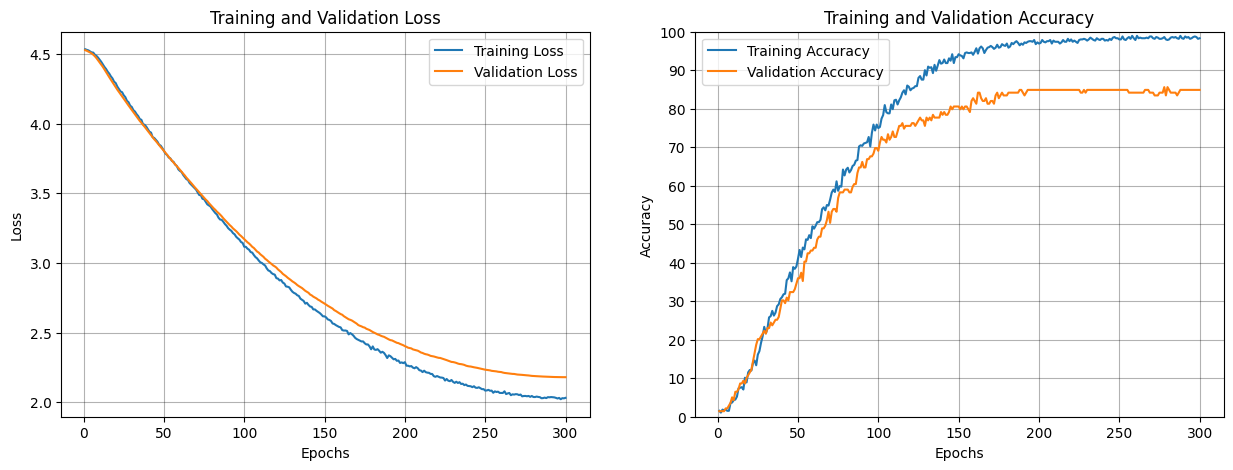

In [ ]:
from matplotlib import pyplot as plt

epochs = range(1, EPOCHS + 1)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(epochs, train_loss_values, label='Training Loss')
ax[0].plot(epochs, val_loss_values, label='Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True, color='black', alpha=0.3)  # Agregar cuadrícula

ax[1].plot(epochs, train_accuracy_values, label='Training Accuracy')
ax[1].plot(epochs, val_accuracy_values, label='Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(True, color='black', alpha=0.3)  # Agregar cuadrícula
ax[1].set_ylim(0, 100)  # Establecer límites de 0 a 100 (si la precisión está en porcentaje)
ax[1].set_yticks(range(0, 101, 10))


plt.show()

In [ ]:
len(valid_pred)

139

In [ ]:
from sklearn.metrics import classification_report

# Convertir valid_y de tensor a un array NumPy
valid_y_numpy = val_y.cpu().detach().numpy()

# Generar el classification report
print('Classification Report:')
print(classification_report(valid_pred, valid_y_numpy, target_names=label_dict.values(), zero_division=1))


Classification Report:
                         precision    recall  f1-score   support

         agradecimiento       1.00      1.00      1.00         2
              despedida       0.00      1.00      0.00         0
      jupiter_atmosfera       1.00      1.00      1.00         2
          jupiter_color       1.00      1.00      1.00         1
 jupiter_descubrimiento       1.00      1.00      1.00         2
          jupiter_lunas       1.00      1.00      1.00         2
           jupiter_masa       1.00      1.00      1.00         2
       jupiter_misiones       1.00      1.00      1.00         1
         jupiter_orbita       1.00      1.00      1.00         1
       jupiter_rotacion       0.50      1.00      0.67         1
     jupiter_superficie       1.00      1.00      1.00         2
         jupiter_tamaño       1.00      0.40      0.57         5
        marte_atmosfera       1.00      1.00      1.00         2
            marte_color       1.00      1.00      1.00         1
 

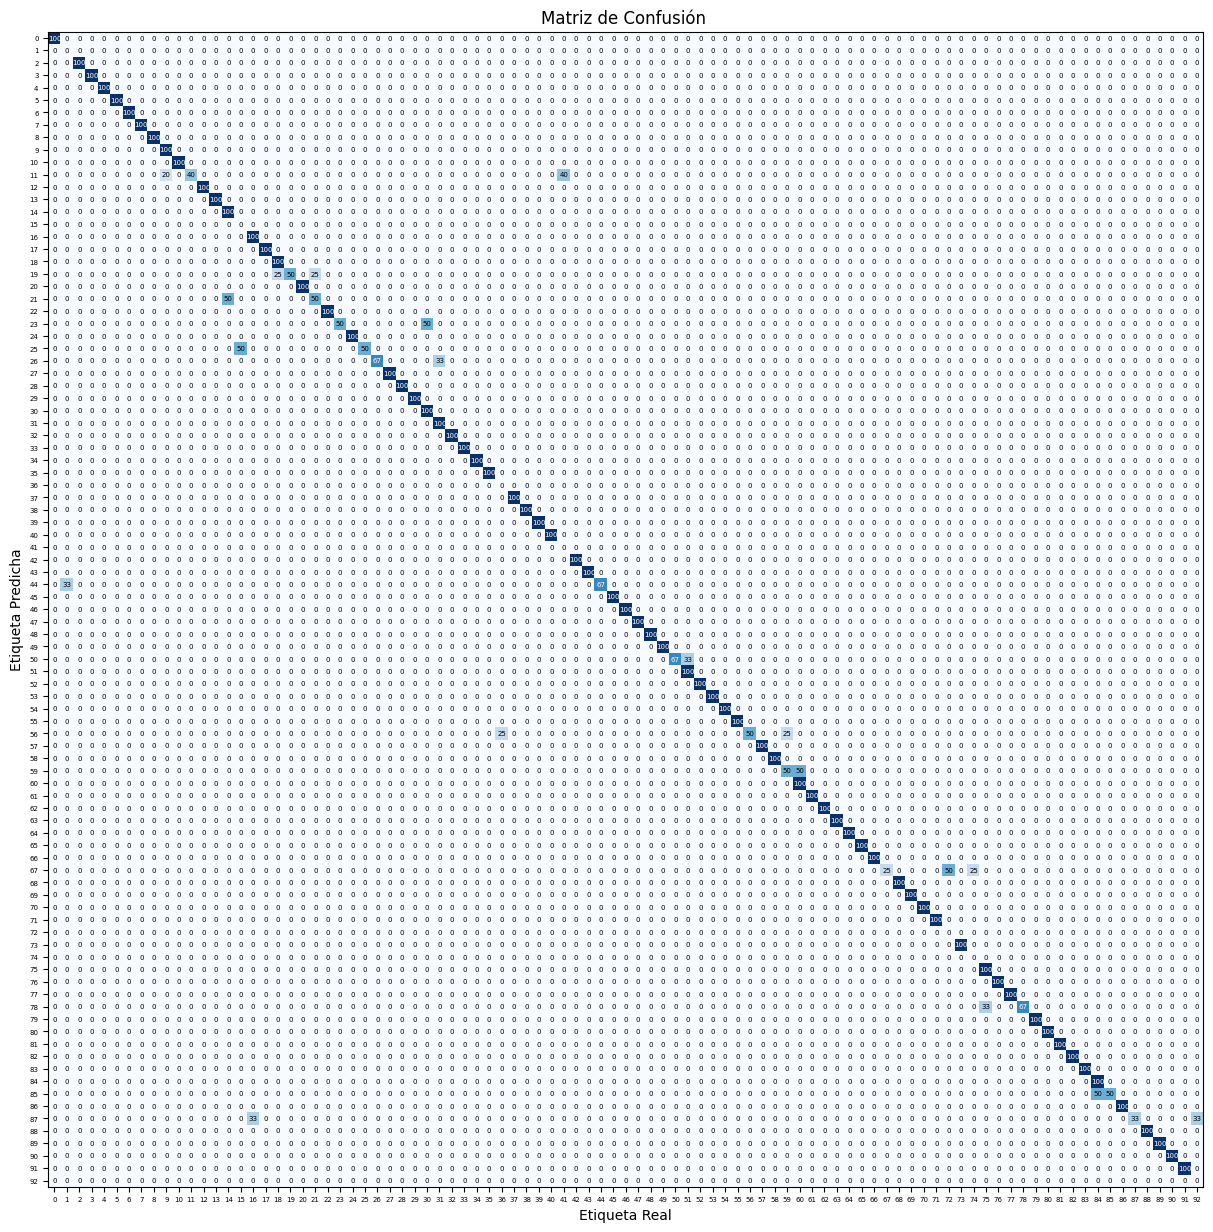

In [ ]:
from sklearn.metrics import confusion_matrix

# Genera la matriz de confusión
cm = confusion_matrix(valid_pred, valid_y_numpy)

# Calcula los porcentajes con manejo de división por cero
cm_sum = cm.sum(axis=1)[:, np.newaxis]
cm_sum[cm_sum == 0] = 1  # Reemplaza los ceros por uno para evitar la división por cero
cm_percentage = cm.astype('float') / cm_sum * 100

# Restaura los ceros en las posiciones originales de la matriz de suma
cm_sum[cm_sum == 1] = 0

# Define las etiquetas de las clases
class_names = [str(i) for i in range(cm.shape[0])]  # Ajustar a la forma correcta de la matriz de confusión

# Ajusta el tamaño de la figura
plt.figure(figsize=(25, 15))   # Cambia las dimensiones según sea necesario

# Crea el plot de la matriz de confusión con porcentajes
plt.imshow(cm_percentage, interpolation='nearest',cmap=plt.cm.Blues)
#plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, fontsize=5)  # Ajusta el tamaño de la fuente en el eje x
plt.yticks(np.arange(len(class_names)), class_names, fontsize=5)  # Ajusta el tamaño de la fuente en el eje y
plt.xlabel('Etiqueta Real', fontsize=10)  # Ajusta el tamaño de la fuente para la etiqueta del eje x
plt.ylabel('Etiqueta Predicha', fontsize=10)  # Ajusta el tamaño de la fuente para la etiqueta del eje y
plt.title('Matriz de Confusión ', fontsize=12)  # Ajusta el tamaño de la fuente para el título

# Añade los valores de los porcentajes de la matriz de confusión a cada celda con texto más pequeño
for i in range(cm_percentage.shape[0]):
    for j in range(cm_percentage.shape[1]):
        plt.text(j, i, f'{cm_percentage[i, j]:.0f}',  # Formatea el texto como porcentaje con dos decimales
                ha="center", va="center",
                fontsize=5,  # Ajusta el tamaño de la fuente en las celdas
                color="white" if cm_percentage[i, j] > 50 else "black")  # Cambia el color del texto según un umbral (opcional)

# Muestra el plot
plt.show()

In [ ]:
test_loss = 0
correct_test = 0
total_test = 0
test_pred = []

model.eval()  # Colocar el modelo en modo de evaluación

with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch
        outputs = model(inputs, masks)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        test_pred.append(predicted.cpu().detach().numpy())  # Guardar las predicciones del conjunto de prueba

test_loss = test_loss / len(test_dataloader)
test_accuracy = (correct_test / total_test) * 100
test_pred = np.concatenate(test_pred)

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 2.2328 - Test Accuracy: 84.29%


In [ ]:
from sklearn.metrics import classification_report

# Convertir valid_y de tensor a un array NumPy
test_y_numpy = test_y.cpu().detach().numpy()

# Generar el classification report
print('Classification Report:')
print(classification_report(test_pred, test_y_numpy, target_names=label_dict.values(), zero_division=1))


Classification Report:
                         precision    recall  f1-score   support

         agradecimiento       1.00      0.50      0.67         2
              despedida       0.50      1.00      0.67         1
      jupiter_atmosfera       1.00      1.00      1.00         1
          jupiter_color       1.00      1.00      1.00         2
 jupiter_descubrimiento       1.00      1.00      1.00         1
          jupiter_lunas       1.00      1.00      1.00         1
           jupiter_masa       0.00      1.00      0.00         0
       jupiter_misiones       1.00      1.00      1.00         2
         jupiter_orbita       1.00      1.00      1.00         2
       jupiter_rotacion       0.00      1.00      0.00         0
     jupiter_superficie       1.00      1.00      1.00         1
         jupiter_tamaño       1.00      0.33      0.50         3
        marte_atmosfera       1.00      1.00      1.00         1
            marte_color       1.00      1.00      1.00         2
 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculando precision, recall y F-score con zero_division=1
precision = precision_score(test_y_numpy, test_pred, average='weighted', zero_division=1)
recall = recall_score(test_y_numpy, test_pred, average='weighted', zero_division=1)
f1 = f1_score(test_y_numpy, test_pred, average='weighted', zero_division=1)

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.9035714285714286
Recall: 0.8428571428571429
F1 Score: 0.8264285714285714


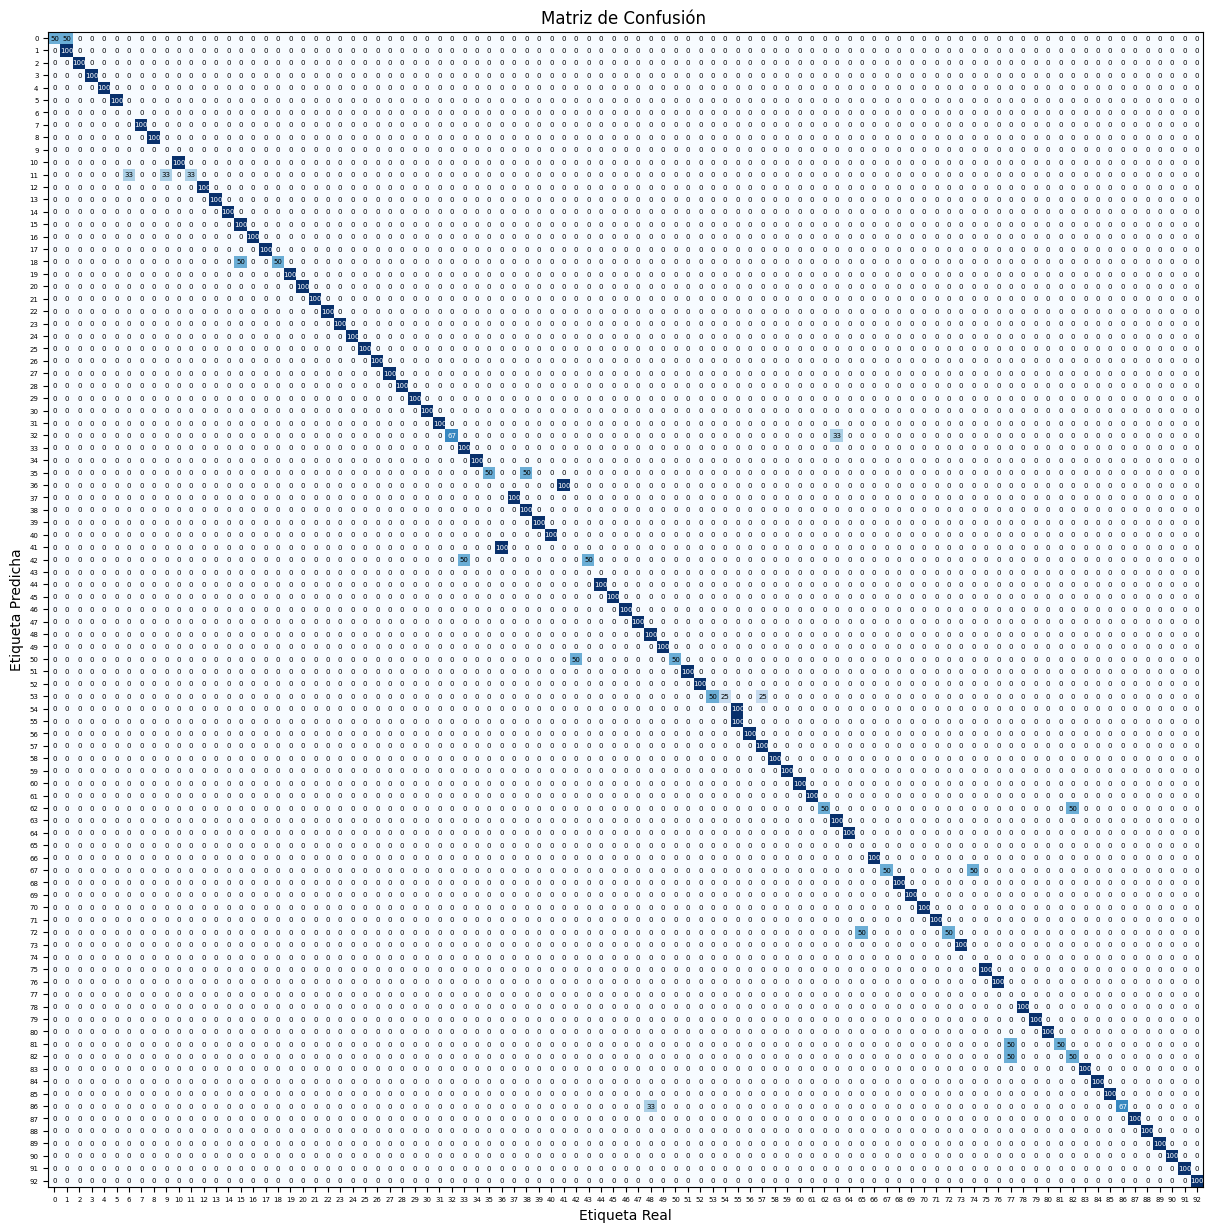

In [ ]:
from sklearn.metrics import confusion_matrix

# Genera la matriz de confusión
cm = confusion_matrix(test_pred, test_y_numpy)

# Calcula los porcentajes con manejo de división por cero
cm_sum = cm.sum(axis=1)[:, np.newaxis]
cm_sum[cm_sum == 0] = 1  # Reemplaza los ceros por uno para evitar la división por cero
cm_percentage = cm.astype('float') / cm_sum * 100

# Restaura los ceros en las posiciones originales de la matriz de suma
cm_sum[cm_sum == 1] = 0

# Define las etiquetas de las clases
class_names = [str(i) for i in range(cm.shape[0])]  # Ajustar a la forma correcta de la matriz de confusión

# Ajusta el tamaño de la figura
plt.figure(figsize=(25, 15))   # Cambia las dimensiones según sea necesario

# Crea el plot de la matriz de confusión con porcentajes
plt.imshow(cm_percentage, interpolation='nearest',cmap=plt.cm.Blues)
#plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, fontsize=5)  # Ajusta el tamaño de la fuente en el eje x
plt.yticks(np.arange(len(class_names)), class_names, fontsize=5)  # Ajusta el tamaño de la fuente en el eje y
plt.xlabel('Etiqueta Real', fontsize=10)  # Ajusta el tamaño de la fuente para la etiqueta del eje x
plt.ylabel('Etiqueta Predicha', fontsize=10)  # Ajusta el tamaño de la fuente para la etiqueta del eje y
plt.title('Matriz de Confusión ', fontsize=12)  # Ajusta el tamaño de la fuente para el título

# Añade los valores de los porcentajes de la matriz de confusión a cada celda con texto más pequeño
for i in range(cm_percentage.shape[0]):
    for j in range(cm_percentage.shape[1]):
        plt.text(j, i, f'{cm_percentage[i, j]:.0f}',  # Formatea el texto como porcentaje con dos decimales
                ha="center", va="center",
                fontsize=5,  # Ajusta el tamaño de la fuente en las celdas
                color="white" if cm_percentage[i, j] > 50 else "black")  # Cambia el color del texto según un umbral (opcional)

# Muestra el plot
plt.show()

In [ ]:
test_df = pd.DataFrame({'pred': test_pred, 'label': test_labels})
test_df

,pred,label
0,11,9
1,0,0
2,61,61
3,71,71
4,28,28
...,...,...
135,49,49
136,89,89
137,78,78
138,39,39


In [ ]:
test_df["text"] = test_text

In [ ]:
print(test_df[test_df['label']!=test_df['pred']].shape)
test_df[test_df['label']!=test_df['pred']][['text','label','pred']].head(5)

(22, 3)


,text,label,pred
0,ser inclinación axial jupiter,9,11
7,ser aurora poder ver pluto,42,50
12,ser cierto neptuno ser planeta mas grande sist...,41,36
28,ser gravedad superficie urano,77,81
31,influir composición atmosfera urano color,74,67


In [ ]:
print(test_df[test_df['label']==test_df['pred']].shape)
test_df[test_df['label']==test_df['pred']][['text','label','pred']].head(5)

(118, 3)


,text,label,pred
1,mil gracia,0,0
2,saber superficie saturno,61,61
3,ser composición superficie tierra,71,71
4,ser perihelio orbita mercurio,28,28
5,depender color jupiter,3,3


In [ ]:
# Guardar los pesos del modelo
ruta_modelo = 'modelo-clasficacion-preguntas-planetas.pth'
# Asegúrate de que el modelo esté en la CPU antes de guardar
model = model.cpu()
torch.save(model.state_dict(), ruta_modelo)

# Guardar el estado del tokenizador
ruta_tokenizador = 'tokenizer-clasficacion-preguntas-planetas'
tokenizer.save_pretrained(ruta_tokenizador)

('tokenizer-clasficacion-preguntas-planetas/tokenizer_config.json',
 'tokenizer-clasficacion-preguntas-planetas/special_tokens_map.json',
 'tokenizer-clasficacion-preguntas-planetas/vocab.txt',
 'tokenizer-clasficacion-preguntas-planetas/added_tokens.json')

In [ ]:
from transformers import BertModel, BertTokenizer
import torch

ruta_modelo = '/content/modelo-clasficacion-preguntas-planetas.pth'
ruta_tokenizador = '/content/tokenizer-clasficacion-preguntas-planetas'

# Inicializar el modelo BERT pre-entrenado
bert_model = BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", return_dict=True)

# Inicializar el modelo FineTuningBERT
model = FineTuningBERT(bert_model)

# Cargar los pesos del modelo guardados
model.load_state_dict(torch.load(ruta_modelo))

# Cargar el tokenizer desde su directorio
tokenizer = BertTokenizer.from_pretrained(ruta_tokenizador)
tokenizer

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTokenizer(name_or_path='/content/tokenizer-clasficacion-preguntas-planetas', vocab_size=31002, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	5: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
# Texto de ejemplo para hacer una predicción
texto_ejemplo = "como afecta la atmosfera de marte a las misiones espaciales"

# Tokenizar el texto de ejemplo y convertirlo a IDs
inputs = tokenizer(texto_ejemplo, return_tensors="pt")
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Realizar la predicción
with torch.no_grad():
    logits = model(input_ids, mask=attention_mask)
    probabilities = torch.nn.functional.softmax(logits, dim=-1)  # Probabilidades de cada clase
    predicted_class = torch.argmax(probabilities, dim=-1).item()  # Obtener la clase predicha

# Obtener la etiqueta predicha usando el label_dict
predicted_label = label_dict[predicted_class]

print("Texto de ejemplo:", texto_ejemplo)
print("Etiqueta predicha:", predicted_label)


Texto de ejemplo: como afecta la atmosfera de marte a las misiones espaciales
Etiqueta predicha: marte_atmosfera


In [ ]:
!python -m spacy download es_core_news_md -q
!pip install pyspellchecker -q

2023-12-17 09:36:38.254961: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 09:36:38.255015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 09:36:38.257021: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 09:36:39.990301: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 15.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [ ]:
import re
import spacy
import pandas as pd
import nltk
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from transformers import BertForSequenceClassification, BertTokenizer
import torch

nltk.download('stopwords')
nlp = spacy.load("es_core_news_md")
stop_words = set(stopwords.words('spanish'))
spell = SpellChecker(language='es')

def minusculas(text):
    # Convertir a minúsculas
    text = text.lower()
    return text

def lematizar(texto):
    doc = nlp(texto)
    lemas = ' '.join([token.lemma_ for token in doc])
    return lemas

def signos_puntuacion(text):
    # Sustituir acentos por letras sin acentos
    text = re.sub(r'[áäâà]', 'a', text)
    text = re.sub(r'[éêèë]', 'e', text)
    text = re.sub(r'[íîìï]', 'i', text)
    text = re.sub(r'[óôòö]', 'o', text)
    text = re.sub(r'[úûùü]', 'u', text)
    # Eliminar signos de puntuación
    text = re.sub(r'[^\w\s]', '', text)
    return text

def remove_stop_words(text):
    words = text.split()
    filtered_text = []
    for word in words:
        if word.lower() not in stop_words:
            filtered_text.append(word)
    return ' '.join(filtered_text)

# Función para corregir el texto
def corregir_texto(texto):
    palabras = texto.split()
    #corregido = [spell.correction(palabra) for palabra in palabras]
    corregido = [spell.correction(palabra) if spell.correction(palabra) is not None else palabra for palabra in palabras]
    texto_corregido = ' '.join(corregido)
    return texto_corregido

ruta_modelo = '/content/modelo-clasficacion-preguntas-planetas.pth'
ruta_tokenizador = '/content/tokenizer-clasficacion-preguntas-planetas'

# Inicializar el modelo BERT pre-entrenado
bert_model = BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", return_dict=True)

# Inicializar el modelo FineTuningBERT
model = FineTuningBERT(bert_model)

# Cargar los pesos del modelo guardados
model.load_state_dict(torch.load(ruta_modelo))

# Cargar el tokenizer desde su directorio
tokenizer = BertTokenizer.from_pretrained(ruta_tokenizador)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Texto de ejemplo para procesar y hacer una predicción
#texto_ejemplo = "como afecta la atmosfera de marte a las misiones espaciales"
#texto_ejemplo = "cuales son los nombres de las lunas de urano"
#texto_ejemplo = "¿Cuáles son las formaciones geológicas más destacadas en la superficie de Mercurio?"
texto_ejemplo = "Tienes algun dato sobre la supercifie de Neptuno"

# Aplicar preprocesamiento al texto de ejemplo
texto_procesado = minusculas(texto_ejemplo)
texto_procesado = signos_puntuacion(texto_procesado)
texto_procesado = corregir_texto(texto_procesado)
texto_procesado = lematizar(texto_procesado)
texto_procesado = remove_stop_words(texto_procesado)

# Tokenizar el texto de ejemplo procesado y convertirlo a IDs
inputs = tokenizer(texto_procesado, return_tensors="pt", padding=True, truncation=True, max_length=128)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Realizar la predicción con probabilidades
with torch.no_grad():
    outputs = model(input_ids, mask=attention_mask)
    probabilities = torch.softmax(outputs, dim=1)

# Obtener la etiqueta predicha
predicted_label_id = torch.argmax(outputs, dim=1).item()
predicted_probability = probabilities[0][predicted_label_id].item()

print("Texto de ejemplo original:", texto_ejemplo)
print("Texto de ejemplo procesado:", texto_procesado)
print("Etiqueta predicha:", label_dict[predicted_label_id])
print("Probabilidad de la etiqueta predicha:", predicted_probability)

all_probabilities = probabilities[0].tolist()
# Obtener la probabilidad más alta
max_probability = max(all_probabilities)
# Obtener índices ordenados por probabilidades en orden descendente
sorted_indexes = sorted(range(len(all_probabilities)), key=lambda k: all_probabilities[k], reverse=True)
# Calcular y mostrar las 10 probabilidades más altas y sus porcentajes con respecto a la más alta
top_n = 10  # Obtener las 10 probabilidades más altas
for i, idx in enumerate(sorted_indexes[:top_n], 1):
    probability = all_probabilities[idx]
    percentage = (probability / max_probability) * 100 if max_probability > 0 else 0
    print(f"{i}. Valor en la lista: {probability}, Porcentaje con respecto al máximo: {percentage:.2f}%, Índice de etiqueta: {idx}, Etiqueta: {label_dict[idx]}")

Texto de ejemplo original: Tienes algun dato sobre la supercifie de Neptuno
Texto de ejemplo procesado: tener algun dato superficie neptuno
Etiqueta predicha: neptuno_superficie
Probabilidad de la etiqueta predicha: 0.1114046722650528
1. Valor en la lista: 0.1114046722650528, Porcentaje con respecto al máximo: 100.00%, Índice de etiqueta: 40, Etiqueta: neptuno_superficie
2. Valor en la lista: 0.030971800908446312, Porcentaje con respecto al máximo: 27.80%, Índice de etiqueta: 73, Etiqueta: urano_atmosfera
3. Valor en la lista: 0.029980342835187912, Porcentaje con respecto al máximo: 26.91%, Índice de etiqueta: 37, Etiqueta: neptuno_misiones
4. Valor en la lista: 0.02246067300438881, Porcentaje con respecto al máximo: 20.16%, Índice de etiqueta: 42, Etiqueta: pluton_atmosfera
5. Valor en la lista: 0.021619541570544243, Porcentaje con respecto al máximo: 19.41%, Índice de etiqueta: 56, Etiqueta: saturno_lunas
6. Valor en la lista: 0.02139059454202652, Porcentaje con respecto al máximo: 1

In [ ]:
import random

# Filtrar el DataFrame para obtener las filas con la etiqueta predicha
filas_etiqueta_predicha = df[df['label_codigo'] == predicted_label_id]

# Seleccionar aleatoriamente una fila
fila_aleatoria = filas_etiqueta_predicha.sample(n=1)

# Obtener el valor de la columna 'respuesta' de la fila seleccionada
respuesta_aleatoria = fila_aleatoria['respuesta'].values[0]

print("Respuesta aleatoria correspondiente a la etiqueta predicha:")
print(respuesta_aleatoria)

Respuesta aleatoria correspondiente a la etiqueta predicha:
Debido a que Neptuno es un planeta gigante gaseoso, no hay una superficie sólida en el planeta.


In [ ]:
import shutil

# Ruta del archivo a guardar en Google Drive
file_to_save = '/content/tokenizer-clasficacion-preguntas-planetas/added_tokens.json'
destination_folder = '/content/drive/MyDrive/Colab Notebooks/transfomer/'  # Ruta de la carpeta en tu Google Drive

# Mover el archivo a Google Drive
shutil.move(file_to_save, destination_folder)